## deep dream tutorial## deep dream tutorial## deep dream tutorial

In [227]:
model = 1
cuda = 1

from keras.utils import to_categorical
from keras import optimizers

import scipy
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# import the model and switch off dropout and fix the parameters:
if cuda==1:
    torch.cuda.set_device(1)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
if cuda==0:
    torch.set_default_tensor_type('torch.FloatTensor')

if model==1:
    vgg16 = torchvision.models.vgg16(pretrained=True)
    list(vgg16.children())[1][2].p = 0.
    list(vgg16.children())[1][2].p = 0.
    from keras.applications.vgg16 import decode_predictions
    for i in vgg16.parameters():
        i.requires_grad = False
    print('Model: ', model)

if model==2:
    iv3 = torchvision.models.inception_v3(pretrained=True)
    from keras.applications.inception_v3 import decode_predictions
    for i in iv3.parameters():
        i.requires_grad = False
    print('Model: ', model)


def scaler(vector, ceiling):
    vector = vector.float()
    min_v = torch.min(vector).float()
    range_v = torch.max(vector) - min_v
    if range_v > 0:
        normalised = (vector - min_v) / range_v * ceiling
    else:
        normalised = torch.zeros(vector.size())
    return normalised

data_dir = '/home/amplifier/home/NEW_DL/img/'

data_transforms = torchvision.transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
    ])

train_dataset = torchvision.datasets.ImageFolder(
    root=data_dir,
    transform=data_transforms
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=3,
    num_workers=0,
    shuffle=True
)

Model:  1


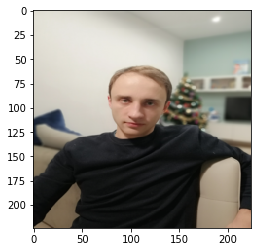

In [241]:
torch.cuda.empty_cache()
# get one image:
bat = list(train_loader)[0]
if model==1:
    dat = bat[0][0,:,:,:].view(1,3,224,224)
#     target = torch.empty(1, dtype=torch.long).random_(1000)
    target = torch.tensor([151], dtype=torch.long)
#     dat = torch.randn(1,3,224,224)
#     target = torch.tensor([torch.argmax(vgg16(dat.cuda()))])
if model==2:
    dat = bat[0][0:2,:,:,:].view(2,3,224,224)
    target = torch.empty(2, dtype=torch.long).random_(1000)
if cuda==1:
    dat = dat.cuda()
if cuda==0:
    dat = dat.cpu()

plt.imshow(dat[0,:,:,:].cpu().detach().numpy().transpose(1,2,0))
dat1 = dat.cpu().detach().numpy()

In [242]:
criterion = nn.CrossEntropyLoss()

if cuda==1:
    x = Variable(dat, requires_grad=True).cuda()
    target = target.cuda()
else:
    x = Variable(dat, requires_grad=True).cpu()
    target = target.cpu()

if model==1:
    output = vgg16(x)
    loss = criterion(output, target)
    
if model==2:
    output = iv3(x)
    loss = criterion(output[0], target)

# loss.backward()

h = []
optimizer = optim.Adam([x])

In [247]:
for j in range(1):
#     target = torch.tensor([torch.argmax(vgg16(dat.cuda()))])
    print('I see:', decode_predictions(to_categorical(target.cpu().detach().numpy(), 1000))[0][0][1])
    for i in range(1100):
        output = vgg16(x)
        loss = criterion(output, target)
        h.append(loss.item())
        loss.backward(retain_graph=True)
        # either:
        x.grad.data = -x.grad.data  # for gradient ascent (remove the - for descent)
        optimizer.step()
        optimizer.zero_grad()
        # or:
        # x.data.sub_(-x.grad.data*0.01) # for gradient ascent (remove the - for descent)
        # x.grad.data.zero_()

I see: Chihuahua


Text(0.5, 1.0, 'Target: Chihuahua,\n Model says: toilet_seat')

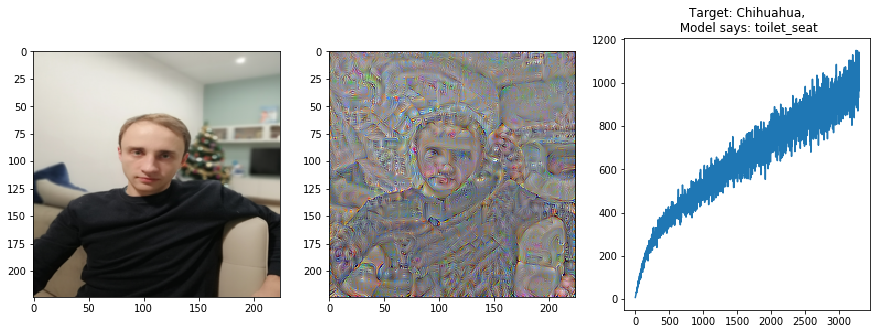

In [248]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(dat1[0,:,:,:].transpose(1,2,0))
plt.subplot(1,3,2)
plt.imshow(scaler(x[0,:,:,:], 1).cpu().detach().numpy().transpose(1,2,0))
plt.subplot(1,3,3)
plt.plot(h)
plt.title('Target: {},\n Model says: {}'.format(decode_predictions(to_categorical(target.cpu().detach().numpy(), 1000))[0][0][1],
                                          decode_predictions(output.cpu().detach().numpy())[0][0][1]))